# Workflow to Validate NISAR L2 Secular Displacement Requirement

**Original code authored by:** David Bekaert, Heresh Fattahi, Eric Fielding, and Zhang Yunjun 

Extensive modifications by Adrian Borsa and Amy Whetter 2022 <br>
Subsequent updates and reformatting by Rob Zinke, Katia Tymofyeveva and Adrian Borsa 2024

<div class="alert alert-warning">
Step 1 of the validation workflow is executed in the <b>ARIA_prep</b> notebook. All processing steps in this notebook MUST be run sequentially, although several are optional and can be skipped.
</div>

<hr/>

## Table of Contents: <a id='TOC'></a>

[**Environment Setup**](#setup)
- [Load Python Packages](#load_packages)
- [Define CalVal Site and Parameters](#set_calval_params)
- [Set Directories and Files](#set_directories)

[**1. Download and Prepare Interferograms**](#prep_ifg)
[Executed in ARIA_prep]

[**2. Generate Time Series from Interferograms**](#gen_ts)
- [2.1. Validate/Modify Interferogram Network](#validate_network)
- [2.2. Generate Quality Control Mask](#generate_mask)
- [2.3. Reference Interferograms To Common Lat/Lon](#common_latlon)
- [2.4. Invert for SBAS Line-of-Sight Timeseries](#invert_SBAS)

[**3. Optional Corrections**](#opt_correction)
- [3.1. Solid Earth Tide Correction](#solid_earth)
- [3.2. Tropospheric Delay Correction](#tropo_corr)
- [3.3. Phase Deramping ](#phase_deramp)
- [3.4. Topographic Residual Correction ](#topo_corr) 

[**4. Decompose InSAR and GNSS Time Series**](#decomp_ts)
- [4.1. Estimate InSAR LOS Velocities](#insar_vel)
- [4.2. Not Used](#empty)
- [4.3. Find Collocated GNSS Stations](#find_gps)  
- [4.4. Get GNSS Position Time Series](#gps_ts) 
- [4.5. Estimate GNSS LOS Velocities](#gps_vel)
- [4.6. Re-reference GNSS and InSAR](#reference)

[**5. Validation Method 1: GNSS-InSAR Direct Comparison**](#validation1)
- [5.1. Make GNSS-InSAR Velocity Residuals at GNSS Station Locations](#make_resid)
- [5.2. Make Double-differenced Velocity Residuals](#make_ddiff)
- [5.3. Secular Requirement Validation: Method 1](#secular_validation_method1)

[**6. Validation Method 2: InSAR-only Structure Function**](#validation2)
- [6.1. Read InSAR Array and Mask Pixels with No Data](#array_mask)
- [6.2. Randomly Sample and Pair Pixels](#array_sample)
- [6.3. Secular Requirement Validation: Method 2](#secular_validation_method2)

[**Appendix: Supplementary Comparisons and Plots**](#appendix)
- [A.1. Compare Raw Velocities](#plot_vel)
- [A.2. Plot Velocity Residuals](#plot_residual)
- [A.3. Plot Double-differenced Residuals](#plot_ddiff)
- [A.4. GNSS Timeseries Plots](#plot_gps_tseries)

<br>
<hr>

<a id='#setup'></a>
## Environment Setup

### Load Python Packages <a id='#load_packages'></a>

In [1]:
import glob
import json
import numpy as np
import os
import pandas as pd
import subprocess

from datetime import datetime as dt
from matplotlib import pyplot as plt
from mintpy.cli import view, plot_network
from mintpy.objects import gnss, timeseries
from mintpy.smallbaselineApp import TimeSeriesAnalysis
from mintpy.utils import ptime, readfile, utils as ut
from pathlib import Path
from scipy import signal
from solid_utils.plotting import display_validation, display_validation_table
from solid_utils.sampling import load_geo, samp_pair, profile_samples, haversine_distance

#Set Global Plot Parameters
plt.rcParams.update({'font.size': 12})

### Define Calval Site and Parameters <a id='set_calval_params'></a>

In [2]:
# Specify a calval location ID from my_sites.txt
site = 'test' 

# Choose the requirement to validate
# Options: 'Secular' 'Coseismic' 'Transient'
requirement = 'Secular' 

# What dataset are you processing?
# Options: 'ARIA_S1' (for Sentinel-1 testing with aria-tools)
dataset = 'ARIA_S1'
aria_gunw_version = '3_0_1'

# The date and version of this Cal/Val run
rundate = '20240821'
version = '1'

# Provide the file where you keep your customized list of sites.
custom_sites = '/home/jovyan/my_sites.txt'

# Enter a username for storing your outputs
if os.path.exists('/home/jovyan/me.txt'):
    with open('/home/jovyan/me.txt') as m:
        you = m.readline().strip()
else:
    you = input('Please type a username for your calval outputs:')
    with open ('/home/jovyan/me.txt', 'w') as m: 
        m.write(you)

# Load metadata for calval locations
with open('/home/jovyan/my_sites.txt','r') as fid:
    sitedata = json.load(fid)
#sitedata['sites'][site]

### Set Directories and Files <a id='set_directories'></a>

In [3]:
# Directory location for Cal/Val data (do not change)
start_directory = '/scratch/nisar-st-calval-solidearth' 

# Working directory for calval processing
work_dir = os.path.join(start_directory, dataset, requirement, site, you, rundate, 'v' + version)
print("  Work directory:", work_dir)

# Directory for storing GUNW interferograms
gunw_dir = os.path.join(work_dir,'products')
print("  GUNW directory:", gunw_dir) 

# Directory for storing MintPy outputs
mintpy_dir = os.path.join(work_dir,'MintPy')
print("MintPy directory:", mintpy_dir)

# Flag missing MintPy directory
if not os.path.exists(mintpy_dir):
    print()
    print('ERROR: Stop! Your MintPy processing directory does not exist for this requirement, site, version, or date of your ATBD run.')
    print('You may need to run the prep notebook first!')
    print()
else:
    os.chdir(mintpy_dir)

# Set MintPy filenames
vel_file = os.path.join(mintpy_dir, 'velocity.h5')
msk_file = os.path.join(mintpy_dir, 'maskConnComp.h5')  # maskTempCoh.h5

  Work directory: /scratch/nisar-st-calval-solidearth/ARIA_S1/Secular/test/aborsa/20240821/v1
  GUNW directory: /scratch/nisar-st-calval-solidearth/ARIA_S1/Secular/test/aborsa/20240821/v1/products
MintPy directory: /scratch/nisar-st-calval-solidearth/ARIA_S1/Secular/test/aborsa/20240821/v1/MintPy


<br>
<hr>

<a id='#prep_ifg'></a>
## 1. Download and Prepare Interferograms 
Executed in *ARIA_prep* notebook

<br>
<hr>

<a id='#gen_ts'></a>
## 2. Generation of Time Series from Interferograms

### 2.1. Validate/Modify Interferogram Network <a id='validate_network'></a>

Add additional parameters to config_file in order to remove selected interferograms, change minimum coherence, etc.

MintPy version 1.6.1, date 2024-07-31
--RUN-at-2024-08-25 05:16:09.905152--
Current directory: /scratch/nisar-st-calval-solidearth/ARIA_S1/Secular/test/aborsa/20240821/v1/MintPy
Run routine processing with smallbaselineApp.py on steps: ['modify_network']
Remaining steps: ['reference_point', 'quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_ionosphere', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: test
Go to work directory: /scratch/nisar-st-calval-solidearth/ARIA_S1/Secular/test/aborsa/20240821/v1/MintPy
read custom template file: /scratch/nisar-st-calval-solidearth/ARIA_S1/Secular/test/aborsa/20240821/v1/MintPy/test.cfg
update default template based on input custom template
No new option value found, skip updating /scratch/nisar-st-calval-solidearth/ARIA_S1/Secular/test/aborsa/202

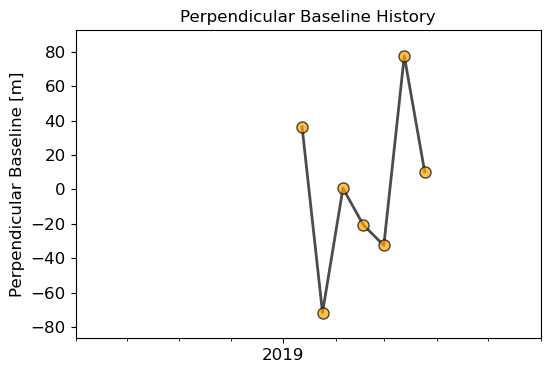

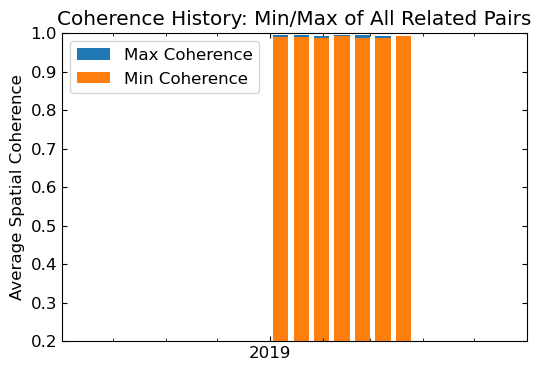

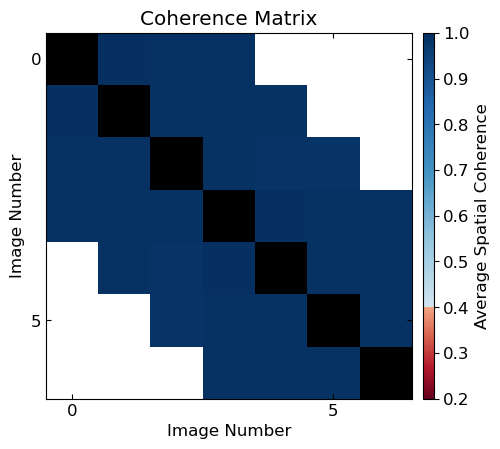

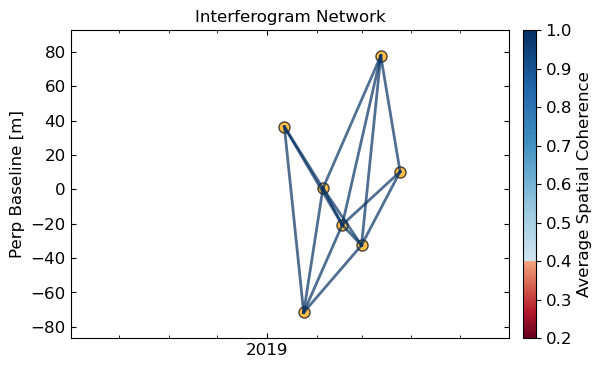

In [4]:
config_file = os.path.join(mintpy_dir,site + '.cfg')
command = 'smallbaselineApp.py ' + str(config_file) + ' --dostep modify_network'
process = subprocess.run(command, shell=True)

plot_network.main(['inputs/ifgramStack.h5'])

### 2.2. Generate Quality Control Mask <a id='generate_mask'></a>

Mask files can be can be used to mask pixels in the time-series processing. Below we generate an initial mask file `maskConnComp.h5` based on the connected components for all the interferograms, which is a metric for unwrapping quality. After time-series analysis is complete, we will calculate a mask from the temporal coherence or variation of phase or displacement with time to make `maskTempCoh.h5`.

input ifgramStack file: inputs/ifgramStack.h5
--------------------------------------------------
update mode: ON
1) output file maskConnComp.h5 already exists.
2) output file is newer than input dataset: connectComponent.
run or skip: skip.
run view.py in MintPy version 1.6.1, date 2024-07-31
input file is mask file: /scratch/nisar-st-calval-solidearth/ARIA_S1/Secular/test/aborsa/20240821/v1/MintPy/maskConnComp.h5 in bool format
file size in y/x: (1130, 2678)
input dataset: "['mask']"
num of datasets in file maskConnComp.h5: 1
datasets to exclude (0):
[]
datasets to display (1):
['mask']
data   coverage in y/x: (0, 0, 2678, 1130)
subset coverage in y/x: (0, 0, 2678, 1130)
data   coverage in lat/lon: (-116.620786685, 35.601652426, -114.389120911, 34.659986136)
subset coverage in lat/lon: (-116.620786685, 35.601652426, -114.389120911, 34.659986136)
------------------------------------------------------------------------
colormap: jet
figure title: maskConnComp
figure size : [10.0, 3.4]
r

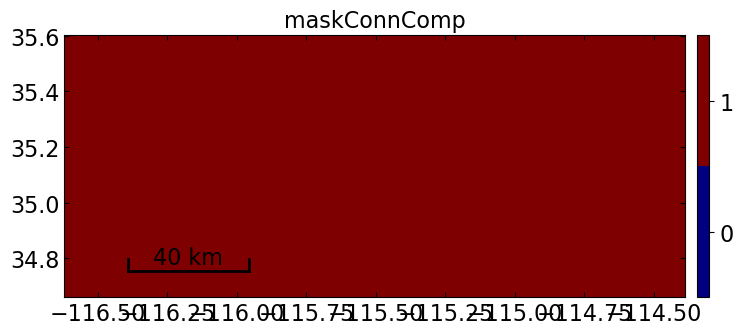

In [5]:
command='generate_mask.py inputs/ifgramStack.h5  --nonzero  -o maskConnComp.h5  --update'
process = subprocess.run(command, shell=True)
view.main(['maskConnComp.h5', 'mask'])

### 2.3. Reference Interferograms To Common Lat/Lon <a id='common_latlon'></a>

In [6]:
command = 'smallbaselineApp.py ' + str(config_file) + ' --dostep reference_point'
process = subprocess.run(command, shell=True)
os.system('info.py inputs/ifgramStack.h5 | egrep "REF_"');

MintPy version 1.6.1, date 2024-07-31
--RUN-at-2024-08-25 05:16:16.636880--
Current directory: /scratch/nisar-st-calval-solidearth/ARIA_S1/Secular/test/aborsa/20240821/v1/MintPy
Run routine processing with smallbaselineApp.py on steps: ['reference_point']
Remaining steps: ['quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_ionosphere', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: test
Go to work directory: /scratch/nisar-st-calval-solidearth/ARIA_S1/Secular/test/aborsa/20240821/v1/MintPy
read custom template file: /scratch/nisar-st-calval-solidearth/ARIA_S1/Secular/test/aborsa/20240821/v1/MintPy/test.cfg
update default template based on input custom template
No new option value found, skip updating /scratch/nisar-st-calval-solidearth/ARIA_S1/Secular/test/aborsa/20240821/v1/MintPy/sm

### 2.4. Invert for SBAS Line-of-Sight Timeseries <a id='invert_SBAS'></a>

In [7]:
command = 'smallbaselineApp.py ' + str(config_file) + ' --dostep invert_network'
process = subprocess.run(command, shell=True)

MintPy version 1.6.1, date 2024-07-31
--RUN-at-2024-08-25 05:16:20.693950--
Current directory: /scratch/nisar-st-calval-solidearth/ARIA_S1/Secular/test/aborsa/20240821/v1/MintPy
Run routine processing with smallbaselineApp.py on steps: ['invert_network']
Remaining steps: ['correct_LOD', 'correct_SET', 'correct_ionosphere', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: test
Go to work directory: /scratch/nisar-st-calval-solidearth/ARIA_S1/Secular/test/aborsa/20240821/v1/MintPy
read custom template file: /scratch/nisar-st-calval-solidearth/ARIA_S1/Secular/test/aborsa/20240821/v1/MintPy/test.cfg
update default template based on input custom template
No new option value found, skip updating /scratch/nisar-st-calval-solidearth/ARIA_S1/Secular/test/aborsa/20240821/v1/MintPy/smallbaselineApp.cfg
read default template file: /scratch/nisar

<br>
<hr>

<a id='opt_correction'></a>
## 3. Optional Corrections

Phase distortions related to solid earth and ocean tidal effects, as well as those due to temporal variations in the vertical stratification of the atmosphere, can be mitigated using the approaches described below. At this point, it is expected that these corrections will not be needed to validate the mission requirements, but they may be used to produce the highest quality data products. Typically, these are applied to the estimated time series product rather than to the individual interferograms, since they are a function of the time of each radar acquisition.

### 3.1. Solid Earth Tides Correction <a id='solid_earth'></a>

[MintPy provides functionality for this correction, but it is not part of this notebook]

### 3.2. Tropospheric Delay Correction <a id='tropo_corr'></a>

Optional atmospheric correction utilizes the PyAPS (Jolivet et al., 2011, Jolivet and Agram, 2012) module within GIAnT (or eventually a merged replacement for GIAnT and MintPy). PyAPS is well documented, maintained and can be freely downloaded. PyAPS is included in GIAnT distribution). PyAPS currently includes support for ECMWF’s ERA-Interim, NOAA’s NARR and NASA’s MERRA weather models. A final selection of atmospheric models to be used for operational NISAR processing will be done during Phase C.

[T]ropospheric delay maps are produced from atmospheric data provided by Global Atmospheric Models. This method aims to correct differential atmospheric delay correlated with the topography in interferometric phase measurements. Global Atmospheric Models (hereafter GAMs)... provide estimates of the air temperature, the atmospheric pressure and the humidity as a function of elevation on a coarse resolution latitude/longitude grid. In PyAPS, we use this 3D distribution of atmospheric variables to determine the atmospheric phase delay on each pixel of each interferogram.

The absolute atmospheric delay is computed at each SAR acquisition date. For a pixel a_i at an elevation z at acquisition date i, the four surrounding grid points are selected and the delays for their respective elevations are computed. The resulting delay at the pixel a_i is then the bilinear interpolation between the delays at the four grid points. Finally, we combine the absolute delay maps of the InSAR partner images to produce the differential delay maps used to correct the interferograms.

REFERENCE : https://github.com/insarlab/pyaps#2-account-setup-for-era5
<br> Read Section 2 for ERA5 [link above] to create an account on the CDS website.

In [8]:
do_tropo_correction = False

if do_tropo_correction:
    if not Use_Staged_Data and not os.path.exists(Path.home()/'.cdsapirc'):
        print('NEEDED to download ERA5, link: https://cds.climate.copernicus.eu/user/register')
        UID = input('Please type your CDS_UID:')
        CDS_API = input('Please type your CDS_API:')
        
        cds_tmp = '''url: https://cds.climate.copernicus.eu/api/v2
        key: {UID}:{CDS_API}'''.format(UID=UID, CDS_API=CDS_API)
        os.system('echo "{cds_tmp}" > ~/.cdsapirc; chmod 600 ~/.cdsapirc'.format(cds_tmp = str(cds_tmp)))
    
    command = 'smallbaselineApp.py ' + str(config_file) + ' --dostep correct_troposphere'
    process = subprocess.run(command, shell=True)
    
    view.main(['inputs/ERA5.h5'])
    timeseries_filename = 'timeseries_ERA5.h5'
else:
    timeseries_filename = 'timeseries.h5'

### 3.3. Phase Deramping <a id='phase_deramp'></a>

In [9]:
command = 'smallbaselineApp.py ' + str(config_file) + ' --dostep deramp'
process = subprocess.run(command, shell=True)

MintPy version 1.6.1, date 2024-07-31
--RUN-at-2024-08-25 05:16:24.010363--
Current directory: /scratch/nisar-st-calval-solidearth/ARIA_S1/Secular/test/aborsa/20240821/v1/MintPy
Run routine processing with smallbaselineApp.py on steps: ['deramp']
Remaining steps: ['correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: test
Go to work directory: /scratch/nisar-st-calval-solidearth/ARIA_S1/Secular/test/aborsa/20240821/v1/MintPy
read custom template file: /scratch/nisar-st-calval-solidearth/ARIA_S1/Secular/test/aborsa/20240821/v1/MintPy/test.cfg
update default template based on input custom template
No new option value found, skip updating /scratch/nisar-st-calval-solidearth/ARIA_S1/Secular/test/aborsa/20240821/v1/MintPy/smallbaselineApp.cfg
read default template file: /scratch/nisar-st-calval-solidearth/ARIA_S1/Secular/test/aborsa/20240821/v1/MintPy/smallbaselineApp.cfg


*

### 3.4. Topographic Residual Correction <a id='topo_corr'></a>

In [10]:
command = 'smallbaselineApp.py ' + str(config_file) + ' --dostep correct_topography'
process = subprocess.run(command, shell=True)

MintPy version 1.6.1, date 2024-07-31
--RUN-at-2024-08-25 05:16:25.112741--
Current directory: /scratch/nisar-st-calval-solidearth/ARIA_S1/Secular/test/aborsa/20240821/v1/MintPy
Run routine processing with smallbaselineApp.py on steps: ['correct_topography']
Remaining steps: ['residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: test
Go to work directory: /scratch/nisar-st-calval-solidearth/ARIA_S1/Secular/test/aborsa/20240821/v1/MintPy
read custom template file: /scratch/nisar-st-calval-solidearth/ARIA_S1/Secular/test/aborsa/20240821/v1/MintPy/test.cfg
update default template based on input custom template
No new option value found, skip updating /scratch/nisar-st-calval-solidearth/ARIA_S1/Secular/test/aborsa/20240821/v1/MintPy/smallbaselineApp.cfg
read default template file: /scratch/nisar-st-calval-solidearth/ARIA_S1/Secular/test/aborsa/20240821/v1/MintPy/smallbaselineApp.cfg


***********

<br>
<hr>

<a id='decomp_ts'></a>
## 4. Estimate InSAR and GNSS Velocities
The approach that will be used for the generation of NISAR L3 products for Requirements 660 and 663 allows for an explicit inclusion of key basis functions (e.g., Heaviside functions, secular rate, etc.) in the InSAR inversion. Modifications to this algorithm may be identified and implemented in response to NISAR Phase C activities. 

### 4.1. Estimate InSAR LOS Velocities <a id='insar_vel'></a>

Given a time series of InSAR LOS displacements, the observations for a given pixel, $U(t)$, can be parameterized as:

$$U(t) = a \;+\; vt \;+\; c_1 cos (\omega_1t - \phi_{1,}) \;+\; c_2 cos (\omega_2t - \phi_2) \;+\; \sum_{j=1}^{N_{eq}} \left( h_j+f_j F_j (t-t_j) \right)H(t - t_j) \;+\; \frac{B_\perp (t)}{R sin \theta}\delta z \;+\; residual$$ 

which includes a constant offset $(a)$, velocity $(v)$, and amplitudes $(c_j)$ and phases $(\phi_j)$ of annual $(\omega_1)$ and semiannual $(\omega_2)$ sinusoidal terms.  Where needed we can include additional complexity, such as coseismic and postseismic processes parameterized by Heaviside (step) functions $H$ and postseismic functions $F$ (the latter typically exponential and/or logarithmic).   $B_\perp(t)$, $R$, $\theta$, and $\delta z$ are, respectively, the perpendicular component of the interferometric baseline relative to the first date, slant range distance, incidence angle and topography error correction for the given pixel. 

Thus, given either an ensemble of interferograms or the output of SBAS (displacement vs. time), we can write the LSQ problem as 

$$ \textbf{G}\textbf{m} = \textbf{d}$$

where $\textbf{G}$ is the design matrix (constructed out of the different functional terms in Equation 2 evaluated either at the SAR image dates for SBAS output, or between the dates spanned by each pair for interferograms), $\textbf{m}$ is the vector of model parameters (the coefficients in Equation 2) and $\textbf{d}$ is the vector of observations.  (In the case of GNSS displacement timeseries, $\textbf{G}, \textbf{d}, \textbf{m}$ are constructed using values evaluated at single epochs corresponding to the GNSS solution times, otherwise the estimate is the same.) 

With this formulation, we can obtain InSAR velocity estimates and their formal uncertainties (including in areas where the expected answer is zero). The default InSAR velocity fit in MintPy is to estimate a mean linear velocity $(v)$ in in the equation, which we do below. 

In [11]:
command = 'smallbaselineApp.py ' + str(config_file) + ' --dostep velocity'
process = subprocess.run(command, shell=True)

# load velocity file
insar_velocities,_ = readfile.read(vel_file, datasetName = 'velocity')  # read velocity file
insar_velocities = insar_velocities * 1000.  # convert velocities from m to mm

# set masked pixels to NaN
msk,_ = readfile.read(msk_file)
insar_velocities[msk == 0] = np.nan
insar_velocities[insar_velocities == 0] = np.nan

# Optionally dump velocity.h5 file metadata
#insar_metadata

MintPy version 1.6.1, date 2024-07-31
--RUN-at-2024-08-25 05:16:26.802574--
Current directory: /scratch/nisar-st-calval-solidearth/ARIA_S1/Secular/test/aborsa/20240821/v1/MintPy
Run routine processing with smallbaselineApp.py on steps: ['velocity']
Remaining steps: ['geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: test
Go to work directory: /scratch/nisar-st-calval-solidearth/ARIA_S1/Secular/test/aborsa/20240821/v1/MintPy
read custom template file: /scratch/nisar-st-calval-solidearth/ARIA_S1/Secular/test/aborsa/20240821/v1/MintPy/test.cfg
update default template based on input custom template
No new option value found, skip updating /scratch/nisar-st-calval-solidearth/ARIA_S1/Secular/test/aborsa/20240821/v1/MintPy/smallbaselineApp.cfg
read default template file: /scratch/nisar-st-calval-solidearth/ARIA_S1/Secular/test/aborsa/20240821/v1/MintPy/smallbaselineApp.cfg


******************** step - velocity ********************

timeseri

### 4.2. Not Used <a id='empty'></a>

### 4.3. Find Collocated GNSS Stations <a id='find_gps'></a>

The project will have access to L2 position data for continuous GNSS stations in third-party networks such NSF’s Plate Boundary Observatory, the HVO network for Hawaii, GEONET-Japan, and GEONET-New Zealand, located in target regions for NISAR solid earth calval. Station data will be post-processed by one or more analysis centers, will be freely available, and will have latencies of several days to weeks, as is the case with positions currently produced by the NSF’s GAGE Facility and separately by the University of Nevada Reno. Networks will contain one or more areas of high-density station coverage (2~20 km nominal station spacing over 100 x 100 km or more) to support validation of L2 NISAR requirements at a wide range of length scales.

In [12]:
# Get analysis metadata from InSAR velocity file
insar_metadata = readfile.read_attribute(vel_file)
lat_step = float(insar_metadata['Y_STEP'])
lon_step = float(insar_metadata['X_STEP'])
(S,N,W,E) = ut.four_corners(insar_metadata)
start_date = insar_metadata.get('START_DATE', None).split('T')[0]
end_date = insar_metadata.get('END_DATE', None).split('T')[0]
start_date_gnss = dt.strptime(start_date, "%Y%m%d")
end_date_gnss = dt.strptime(end_date, "%Y%m%d")

# Get center lat/lon of analysis region
bbox = sitedata['sites'][site]['analysis_region'].replace("'","").split()
lat0 = (float(bbox[0]) + float(bbox[1]))/2
lon0 = (float(bbox[2]) + float(bbox[3]))/2
# Identify geometry file x/y location associated with center lat/lon
geom_obj = mintpy_dir + '/inputs/geometryGeo.h5'
atr = readfile.read_attribute(geom_obj)
coord = ut.coordinate(atr, lookup_file=geom_obj)
y, x = coord.geo2radar(lat0, lon0)[0:2]
y = max(0, y);  y = min(int(atr['LENGTH'])-1, y)
x = max(0, x);  x = min(int(atr['WIDTH'])-1, x)
# Write out inclination/azimuth at specified x/y location
kwargs = dict(box=(x,y,x+1,y+1))
inc_angle = readfile.read(geom_obj, datasetName='incidenceAngle', **kwargs)[0][0,0]
az_angle  = readfile.read(geom_obj, datasetName='azimuthAngle',   **kwargs)[0][0,0]

# Set GNSS Parameters
gnss_completeness_threshold = 0.9    #0.9  #percent of data timespan with valid GNSS epochs
gnss_residual_stdev_threshold = 10.  #0.03  #max threshold standard deviation of residuals to linear GNSS fit

# Search for collocated GNSS stations
site_names, site_lats, site_lons = gnss.search_gnss(SNWE=(S,N,W,E), start_date=start_date, end_date=end_date)
site_names = [str(stn) for stn in site_names]

load 22046 GNSS sites with fields: site lat lon start_date end_date num_solution
keep sites within SNWE of (34.659986136, 35.601652426, -116.620786685, -114.38912091099999): [31]
keep sites with end_date >= 20190112: [27]
keep sites with start_date <= 20190325: [26]
keep sites with # of solutions >= 50: [26]
['AZBH' 'AZFM' 'BKAP' 'CAB5' 'CDMT' 'GMRC' 'HCMN' 'HOME' 'I40A' 'LDSW'
 'NDAP' 'NVLA' 'NVSL' 'P603' 'P611' 'P614' 'P617' 'P618' 'P619' 'P621'
 'P622' 'P625' 'P626' 'PIUT' 'RAGG' 'THUM']
Initial list of 26 stations used in analysis:
['AZBH', 'AZFM', 'BKAP', 'CAB5', 'CDMT', 'GMRC', 'HCMN', 'HOME', 'I40A', 'LDSW', 'NDAP', 'NVLA', 'NVSL', 'P603', 'P611', 'P614', 'P617', 'P618', 'P619', 'P621', 'P622', 'P625', 'P626', 'PIUT', 'RAGG', 'THUM']


### 4.4. Get GNSS Position Time Series <a id='gps_ts'></a>

In [13]:
use_stn = []  #stations to keep
bad_stn = []  #stations to toss
use_lats = [] 
use_lons = []

for counter, stn in enumerate(site_names):
    gnss_obj = gnss.get_gnss_class('UNR')(site = stn, data_dir = os.path.join(mintpy_dir,'GNSS'))
    gnss_obj.open(print_msg=False)
    
    # count number of dates in time range
    dates = gnss_obj.dates
    range_days = (end_date_gnss - start_date_gnss).days
    gnss_count = np.histogram(dates, bins=[start_date_gnss, end_date_gnss])
    gnss_count = int(gnss_count[0][0])

    # for this quick screening check of data quality, we use constant incidence and azimuth angles 
    # get standard deviation of residuals to linear fit
    disp_los = ut.enu2los(gnss_obj.dis_e, gnss_obj.dis_n, gnss_obj.dis_u, inc_angle, az_angle)
    disp_detrended = signal.detrend(disp_los)
    stn_stdv = np.std(disp_detrended)
   
    # select GNSS stations based on data completeness and scatter of residuals
    disp_detrended = signal.detrend(disp_los)
    if range_days*gnss_completeness_threshold <= gnss_count:
        if stn_stdv > gnss_residual_stdev_threshold:
            bad_stn.append(stn)
        else:
            use_stn.append(stn)
            use_lats.append(site_lats[counter])
            use_lons.append(site_lons[counter])
    else:
        bad_stn.append(stn)

site_names = use_stn
site_lats = use_lats
site_lons = use_lons

# [optional] manually remove additional stations
gnss_to_remove=[]

for i, gnss_site in enumerate(gnss_to_remove):
    if gnss_site in site_names:
        site_names.remove(gnss_site)
    if gnss_site not in bad_stn:
        bad_stn.append(gnss_site)

print("\nFinal list of {} stations used in analysis:".format(len(site_names)))
print(site_names)
print("List of {} stations removed from analysis".format(len(bad_stn)))
print(bad_stn)


Final list of 22 stations used in analysis:
['AZBH', 'AZFM', 'BKAP', 'CAB5', 'CDMT', 'GMRC', 'HCMN', 'I40A', 'NDAP', 'NVLA', 'NVSL', 'P603', 'P611', 'P614', 'P617', 'P618', 'P619', 'P621', 'P622', 'P625', 'P626', 'RAGG']
List of 4 stations removed from analysis
['HOME', 'LDSW', 'PIUT', 'THUM']


### 4.5. Estimate GNSS LOS Velocities <a id='gps_vel'></a>

In [45]:
gnss_velocities = gnss.get_los_obs(insar_metadata, 
                            'velocity', 
                            site_names, 
                            start_date=start_date,
                            end_date=end_date,
                            gnss_comp='enu2los', 
                            redo=True)

# scale site velocities from m/yr to mm/yr
gnss_velocities *= 1000.

print('\n site   vel_los [mm/yr]')
print(np.array([site_names, gnss_velocities]).T)

default GNSS observation file name: /scratch/nisar-st-calval-solidearth/ARIA_S1/Secular/test/aborsa/20240821/v1/MintPy/gnss_enu2los_UNR.csv
calculating GNSS observation ...
use incidence / azimuth angle from file: geometryGeo.h5
[==================================================] 22/22 RAGG    7s /     0s 
write GNSS observations to file: /scratch/nisar-st-calval-solidearth/ARIA_S1/Secular/test/aborsa/20240821/v1/MintPy/gnss_enu2los_UNR.csv

 site   vel_los [mm/yr]
[['AZBH' '-22.401701']
 ['AZFM' '-10.713866']
 ['BKAP' '-20.875044']
 ['CAB5' '-15.745759']
 ['CDMT' '-27.750486']
 ['GMRC' '-20.832077']
 ['HCMN' '-28.793802']
 ['I40A' '-26.686752']
 ['NDAP' '-21.122967']
 ['NVLA' '-29.423468']
 ['NVSL' '-21.138838']
 ['P603' '-25.394445']
 ['P611' '-18.327124']
 ['P614' '-22.829256']
 ['P617' '-28.63001']
 ['P618' '-18.583654']
 ['P619' '-29.164755']
 ['P621' '-26.354073']
 ['P622' '-20.44073']
 ['P625' '-23.391771']
 ['P626' '-12.306369']
 ['RAGG' '-21.68793']]


### 4.6. Re-reference GNSS and InSAR <a id='reference'></a>

Using GNSS reference station:  P619


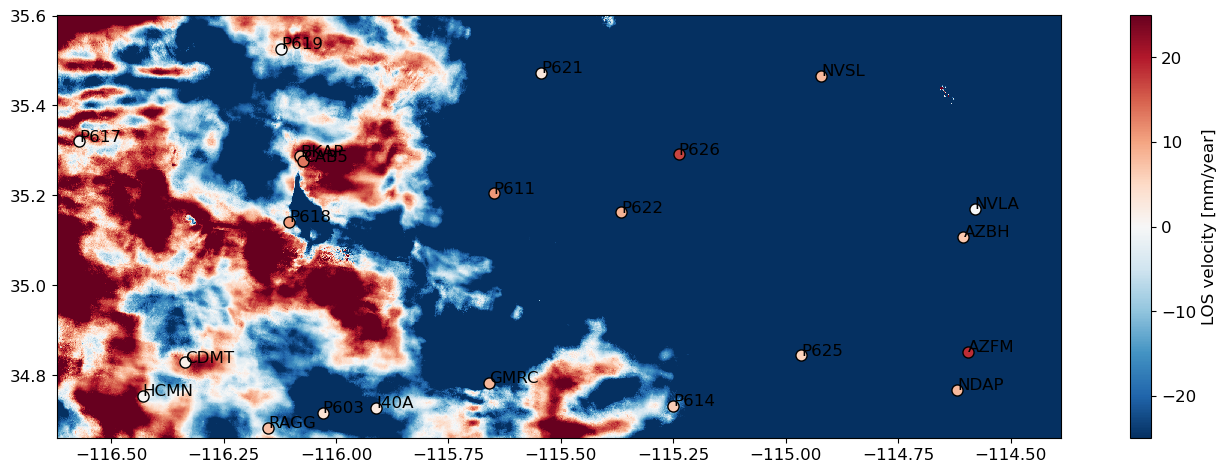

In [15]:
# reference GNSS stations to GNSS reference site
print("Using GNSS reference station: ", sitedata['sites'][site]['gps_ref_site_name'])
ref_site_ind = site_names.index(sitedata['sites'][site]['gps_ref_site_name'])
gnss_velocities = gnss_velocities - gnss_velocities[ref_site_ind]

# reference InSAR to GNSS reference site
ref_site_lat = float(site_lats[ref_site_ind])
ref_site_lon = float(site_lons[ref_site_ind])
ref_y, ref_x = ut.coordinate(insar_metadata).geo2radar(ref_site_lat, ref_site_lon)[:2]
insar_velocities = insar_velocities - insar_velocities[ref_y, ref_x]

# plot GNSS stations on InSAR velocity field
vmin, vmax = -25, 25
cmap = plt.get_cmap('RdBu_r')

fig, ax = plt.subplots(figsize=[18, 5.5])
cax = ax.imshow(insar_velocities, cmap=cmap, vmin=vmin, vmax=vmax, interpolation='nearest', extent=(W, E, S, N))
cbar = fig.colorbar(cax, ax=ax)
cbar.set_label('LOS velocity [mm/year]')

for lat, lon, obs in zip(site_lats, site_lons, gnss_velocities):
    color = cmap((obs - vmin)/(vmax - vmin))
    ax.scatter(lon, lat, color=color, s=8**2, edgecolors='k')
for i, label in enumerate(site_names):
     plt.annotate(label, (site_lons[i], site_lats[i]), color='black')

out_fig = os.path.abspath('vel_insar_vs_gnss.png')
fig.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)

<div class="alert alert-info">
<b>Note :</b> 
Negative values indicates that target is moving away from the radar (i.e., subsidence in case of vertical deformation).
Positive values indicates that target is moving towards the radar (i.e., uplift in case of vertical deformation). 
</div>

<br>
<hr>

<a id='validation1'></a>
## 5. Validation Method 1: GNSS-InSAR Direct Comparison 

### 5.1. Make GNSS-InSAR Velocity Residuals at GNSS Station Locations <a id='make_resid'></a>

In [16]:
#Set Parameters
pixel_radius = 5   #number of InSAR pixels to average for comparison with GNSS

#Create dictionary with the stations as the key and all their info as an array 
stn_dict = {}

#Loop over GNSS station locations
for i in range(len(site_names)): 
    
    # convert GNSS station lat/lon information to InSAR x/y grid
    stn_lat = site_lats[i]
    stn_lon = site_lons[i]
    x_value = round((stn_lon - W)/lon_step)
    y_value = round((stn_lat - N)/lat_step)
    
    # get velocities and residuals
    gnss_site_vel = gnss_velocities[i]
    #Caution: If you expand the radius parameter farther than the bounding grid it will break. 
    #To fix, remove the station in section 4 when the site_names list is filtered
    vel_px_rad = insar_velocities[y_value-pixel_radius:y_value+1+pixel_radius, 
                     x_value-pixel_radius:x_value+1+pixel_radius]
    insar_site_vel = np.median(vel_px_rad)
    residual = gnss_site_vel - insar_site_vel

    # populate data structure
    values = [x_value, y_value, insar_site_vel, gnss_site_vel, residual, stn_lat, stn_lon]
    stn = site_names[i]
    stn_dict[stn] = values

# extract data from structure
res_list = []
insar_site_vels = []
gnss_site_vels = []
lat_list = []
lon_list = []
for i in range(len(site_names)): 
    stn = site_names[i]
    insar_site_vels.append(stn_dict[stn][2])
    gnss_site_vels.append(stn_dict[stn][3])
    res_list.append(stn_dict[stn][4])
    lat_list.append(stn_dict[stn][5])
    lon_list.append(stn_dict[stn][6])
num_stn = len(site_names) 
print('Finish creating InSAR residuals at GNSS sites')

Finish creating InSAR residuals at GNSS sites


### 5.2. Make Double-Differenced Velocity Residuals <a id='make_ddiff'></a>

In [17]:
diff_res_list = []
stn_dist_list = []
n_gnss_sites = len(site_names)

# loop over stations
for i in range(n_gnss_sites - 1):
    stn1 = site_names[i]
    for j in range(i + 1, n_gnss_sites):
        stn2 = site_names[j]

        # calculate GNSS and InSAR velocity differences between stations
        gnss_vel_diff = stn_dict[stn1][3] - stn_dict[stn2][3]
        insar_vel_diff = stn_dict[stn1][2] - stn_dict[stn2][2]

        # calculate GNSS vs InSAR differences (double differences) between stations
        diff_res = gnss_vel_diff - insar_vel_diff
        diff_res_list.append(diff_res)

        # get distance (km) between stations using Haversine formula
        # index 5 is lat, 6 is lon
        stn_dist = haversine_distance(stn_dict[stn1][6], stn_dict[stn1][5], stn_dict[stn2][6], stn_dict[stn2][5])
        stn_dist_list.append(stn_dist)

# Write data for statistical tests
gnss_site_dist = np.array(stn_dist_list)
double_diff_rel_measure = np.array(np.abs(diff_res_list))
ndx = np.argsort(gnss_site_dist)

### 5.3. Secular Requirement Validation: Method 1 <a id='secular_validation_method1'></a>

We assume that the distribution of residuals is Gaussian and that the requirement success threshold represents a 1-sigma limit within which we expect 68.3% of residuals to lie.

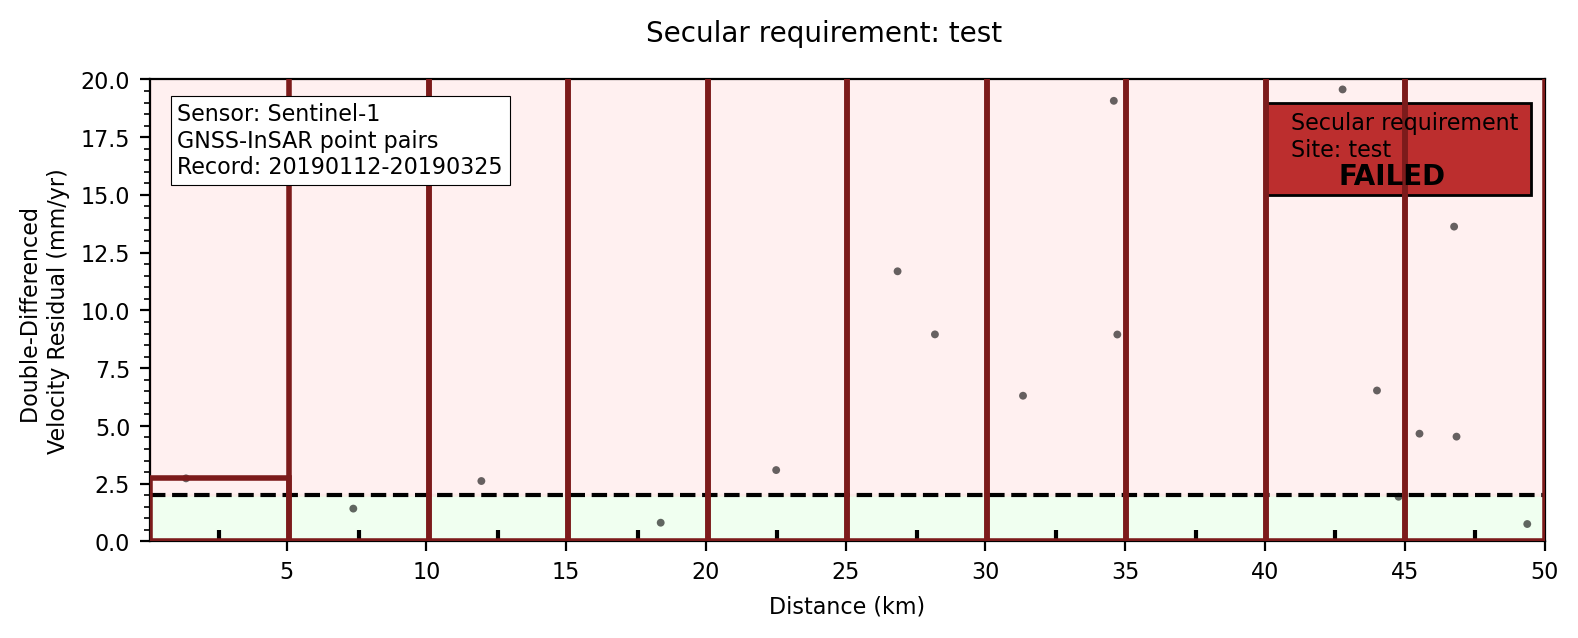

In [18]:
# Define requirement
secular_threshold_rqmt = 2  # mm/yr
secular_distance_rqmt = [0.1, 50.0]  # km

# Validation parameters
n_bins = 10
threshold = 0.683  

# Validation figure and assessment
validation_table, fig = display_validation(gnss_site_dist,                      # binned distance for point
                                           double_diff_rel_measure,             # binned double-difference velocities mm/yr
                                           site,                                # cal/val site name
                                           start_date,                          # start date of InSAR dataset
                                           end_date,                            # end date of InSAR dataset 
                                           requirement=secular_threshold_rqmt,  # measurement requirement to meet, e.g 2 mm/yr for 3 years of data over 0.1-50km
                                           distance_rqmt=secular_distance_rqmt, # distance over requirement is to meet, e.g. over length scales of 0.1-50 km [0.1, 50] 
                                           n_bins=n_bins,                       # number of bins, to collect statistics 
                                           threshold=threshold,                 # quantile threshold for point-pairs that pass requirement, e.g. 0.683 - we expect 68.3% of residuals to lie. 
                                           sensor='Sentinel-1',                 # sensor that is validated, Sentinel-1 or NISAR
                                           validation_type='secular',           # validation for: secular, transient, coseismic requirement
                                           validation_data='GNSS')              # validation method: GNSS - Method 1, InSAR - Method 2

out_fig = os.path.abspath('secular_insar-gnss_velocity_vs_distance.png')
fig.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=30)

In [19]:
display_validation_table(validation_table)

This velocity dataset does not pass the requirement.


,total_count[#],passed_req.[#],passed_pc,passed_req [>68.3%]
distance[km],,,,
"(0.1, 5.09]",1,0,0%,False
"(5.09, 10.08]",2,1,50%,False
"(10.08, 15.07]",3,0,0%,False
"(15.07, 20.06]",3,1,33%,False
"(20.06, 25.05]",3,0,0%,False
"(25.05, 30.04]",6,0,0%,False
"(30.04, 35.03]",7,0,0%,False
"(35.03, 40.02]",7,0,0%,False
"(40.02, 45.01]",8,1,12%,False


<div class="alert alert-warning">
Validation Method 1: success for a baseline distance bin occurs when the percentage of residuals within the requirement success threshold is >0.683
</div>

<br>
<hr>

<a id='validation2'></a>
## 6. Validation Method 2: InSAR-only Structure Function

In Validation Method 2, we use a time interval and area where we assume no deformation.  As with Method 1, we assume that the distribution of residuals is Gaussian and that the requirement success threshold represents a 1-sigma limit within which we expect 68.3% of residuals to lie.

### 6.1. Read InSAR Array and Mask Pixels with no Data <a id='array_mask'></a>

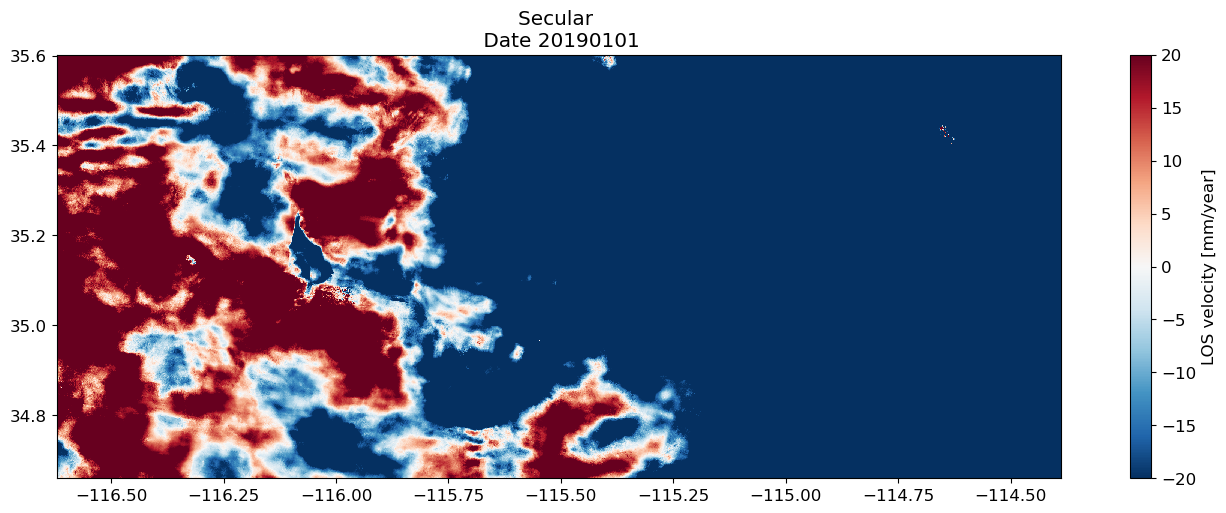

In [20]:
# use the assumed non-earthquake displacement as the insar_displacment for statistics and convert to mm
insar_velocities,_ = readfile.read(vel_file, datasetName = 'velocity')  #read velocity
velStart = sitedata['sites'][site]['download_start_date']
insar_velocities = insar_velocities * 1000.  # convert velocities from m to mm

# set masked pixels to NaN
msk,_ = readfile.read(msk_file)
insar_velocities[msk == 0] = np.nan
insar_velocities[insar_velocities == 0] = np.nan

# display map of velocity data after masking
cmap = plt.get_cmap('RdBu_r')
fig, ax = plt.subplots(figsize=[18, 5.5])
img1 = ax.imshow(insar_velocities, cmap=cmap, vmin=-20, vmax=20, interpolation='nearest', extent=(W, E, S, N))
ax.set_title("Secular \n Date "+velStart)
cbar1 = fig.colorbar(img1, ax=ax)
cbar1.set_label('LOS velocity [mm/year]')

### 6.2. Randomly Sample Pixels and Pair Them Up with Option to Remove Trend <a id='remove_trend'></a>

In [21]:
# Define requirement
secular_threshold_rqmt = 2  # mm/yr
secular_distance_rqmt = [0.1, 50.0]  # km

sample_mode = 'points'  # 'points' or 'profile'
# note that the 'profile' method may take significantly longer

# Collect samples using the specified method
if sample_mode in ['points']:
    X0,Y0 = load_geo(insar_metadata)
    X0_2d,Y0_2d = np.meshgrid(X0,Y0)

    insar_sample_dist, insar_rel_measure = samp_pair(X0_2d, Y0_2d, insar_velocities, num_samples=1000000)

elif sample_mode in ['profile']:
    # Sample grid setup
    length, width = int(insar_metadata['LENGTH']), int(insar_metadata['WIDTH'])
    X = np.linspace(W+lon_step, E-lon_step, width)  # longitudes
    Y = np.linspace(N+lat_step, S-lat_step, length)  # latitudes
    X_coords, Y_coords = np.meshgrid(X, Y)

    # Draw random samples from map (without replacement)
    num_samples = 20000
    
    # Retrieve profile samples
    insar_sample_dist, insar_rel_measure = profile_samples(\
                    x=X_coords.reshape(-1,1),
                    y=Y_coords.reshape(-1,1),
                    data=insar_velocities,
                    metadata=insar_metadata,
                    len_rqmt=secular_distance_rqmt,
                    num_samples=num_samples)

### 6.3. Secular Requirement Validation: Method 2  <a id='secular_validation_method2'></a>

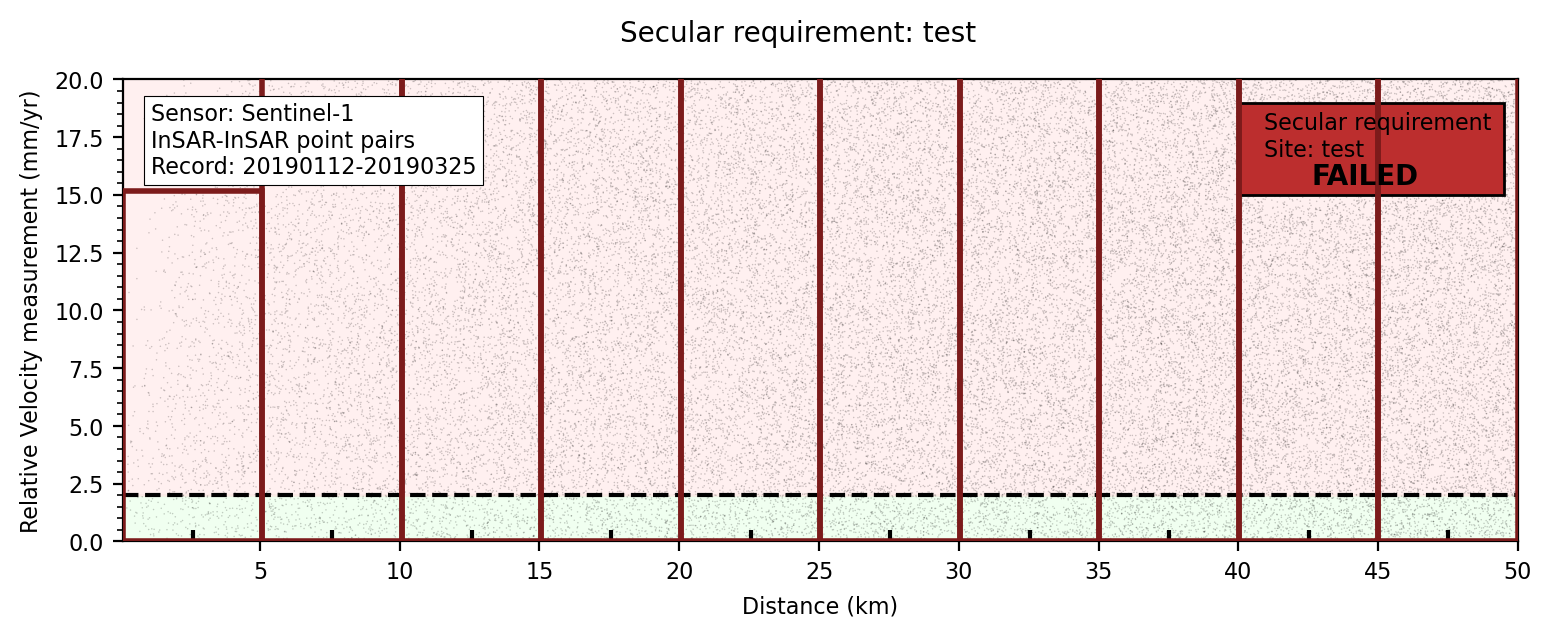

In [22]:
# Validation parameters
n_bins = 10
threshold = 0.683  

# Validation figure and assessment
validation_table, fig = display_validation(insar_sample_dist,              # binned distance for point
                                           insar_rel_measure,              # binned relative velocities mm/yr
                                           site,                           # cal/val site name
                                           start_date,                     # start date of InSAR dataset
                                           end_date,                       # end date of InSAR dataset 
                                           requirement=secular_threshold_rqmt,  # measurement requirement to meet, e.g 2 mm/yr for 3 years of data over 0.1-50km
                                           distance_rqmt=secular_distance_rqmt,  # distance over requirement is to meet, e.g. over length scales of 0.1-50 km [0.1, 50] 
                                           n_bins=n_bins,                  # number of bins, to collect statistics 
                                           threshold=threshold,            # quantile threshold for point-pairs that pass requirement, e.g. 0.683 - we expect 68.3% of residuals to lie. 
                                           sensor='Sentinel-1',            # sensor that is validated, Sentinel-1 or NISAR
                                           validation_type='secular',      # validation for: secular, transient, coseismic requirement
                                           validation_data='InSAR')        # validation method: GNSS - Method 1, InSAR - Method 2

out_fig = os.path.abspath('secular_insar-only_vs_distance_'+site+'_date'+velStart+'.png')
fig.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)

In [23]:
display_validation_table(validation_table)

This velocity dataset does not pass the requirement.


,total_count[#],passed_req.[#],passed_pc,passed_req [>68.3%]
distance[km],,,,
"(0.1, 5.09]",1836,206,11%,False
"(5.09, 10.08]",5148,311,6%,False
"(10.08, 15.07]",8221,407,5%,False
"(15.07, 20.06]",10889,472,4%,False
"(20.06, 25.05]",13263,528,4%,False
"(25.05, 30.04]",15228,546,4%,False
"(30.04, 35.03]",17104,574,3%,False
"(35.03, 40.02]",18735,638,3%,False
"(40.02, 45.01]",20075,656,3%,False


<div class="alert alert-warning">
Final result Method 2—
    68% of points below the requirements line is success
</div>


<br>
<hr>

<a id='appendix'></a>
## Appendix: Supplementary Comparisons and Plots

### A.1. Compare Raw Velocities <a id='compare_raw'></a>

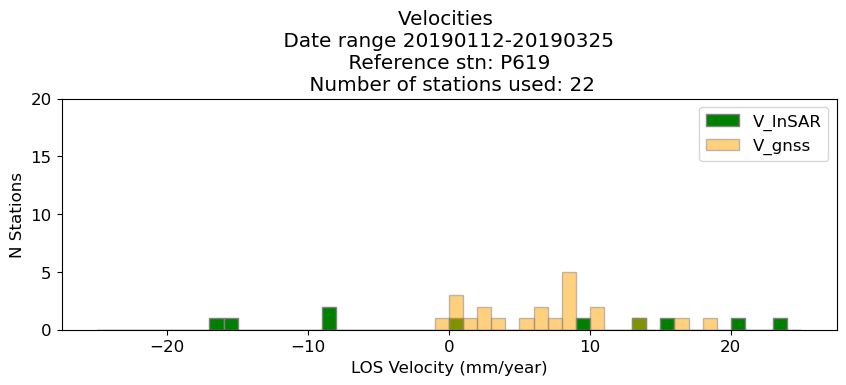

In [24]:
vmin, vmax = -25, 25
plt.figure(figsize=(10,3))
plt.hist(insar_site_vels, range=[vmin, vmax], bins=50, color="green", edgecolor='grey', label='V_InSAR')
plt.hist(gnss_site_vels, range=[vmin, vmax], bins=50, color="orange", edgecolor='grey', label='V_gnss', alpha=0.5)
plt.legend(loc='upper right')
plt.title(f"Velocities \n Date range {start_date}-{end_date} \n Reference stn: {sitedata['sites'][site]['gps_ref_site_name']} \n Number of stations used: {num_stn}")
plt.xlabel('LOS Velocity (mm/year)')
plt.ylabel('N Stations')
plt.ylim(0,20)
plt.show()

### A.2. Plot Velocity Residuals <a id='plot_residuals'></a>

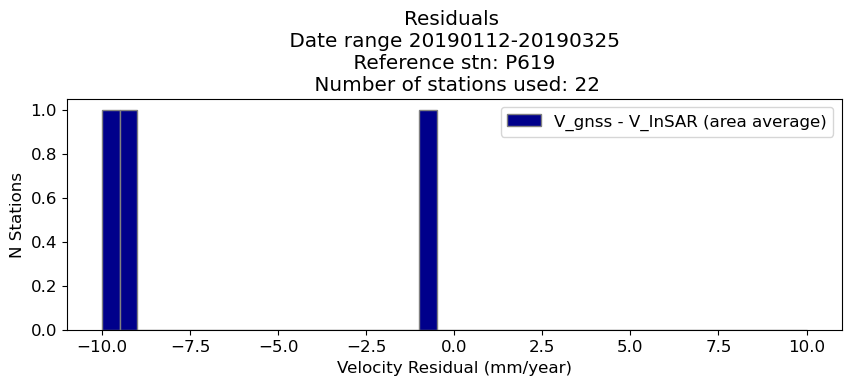

In [25]:
vmin, vmax = -10, 10
plt.figure(figsize=(10,3))
plt.hist(res_list, bins = 40, range=[vmin,vmax], edgecolor='grey', color="darkblue", linewidth=1, label='V_gnss - V_InSAR (area average)')
plt.legend(loc='upper right')
plt.title(f"Residuals \n Date range {start_date}-{end_date} \n Reference stn: {sitedata['sites'][site]['gps_ref_site_name']} \n Number of stations used: {num_stn}")
plt.xlabel('Velocity Residual (mm/year)')
plt.ylabel('N Stations')
plt.show()

### A.3. Plot Double Difference Residuals <a id='plot_ddiff'></a>

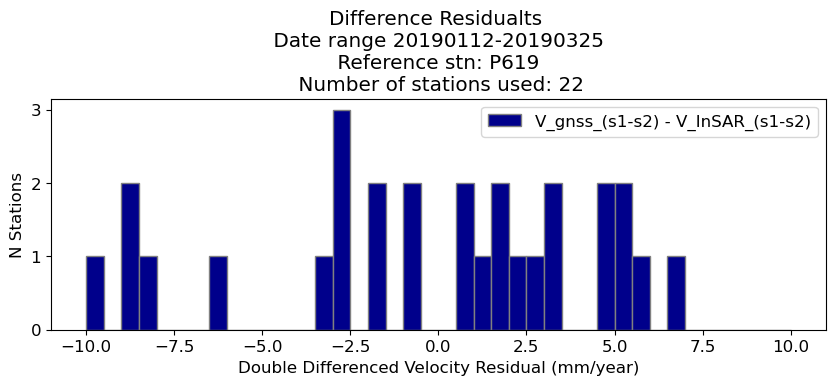

In [26]:
plt.figure(figsize=(10,3))
plt.hist(diff_res_list, range = [vmin, vmax],bins = 40, color = "darkblue",edgecolor='grey',label='V_gnss_(s1-s2) - V_InSAR_(s1-s2)')
plt.legend(loc='upper right')
plt.title(f"Difference Residualts \n Date range {start_date}-{end_date} \n Reference stn: {sitedata['sites'][site]['gps_ref_site_name']} \n Number of stations used: {num_stn}")
plt.xlabel('Double Differenced Velocity Residual (mm/year)')
plt.ylabel('N Stations')
plt.show()

### A.4. GNSS Timeseries Plots <a id='plot_gps_tseries'></a>

reading timeseries from file: /scratch/nisar-st-calval-solidearth/ARIA_S1/Secular/test/aborsa/20240821/v1/MintPy/timeseries.h5
[==================================================] RAGG 22/22    4s /     0s

/tmp/ipykernel_3811/284353324.py:52: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(10, 3))


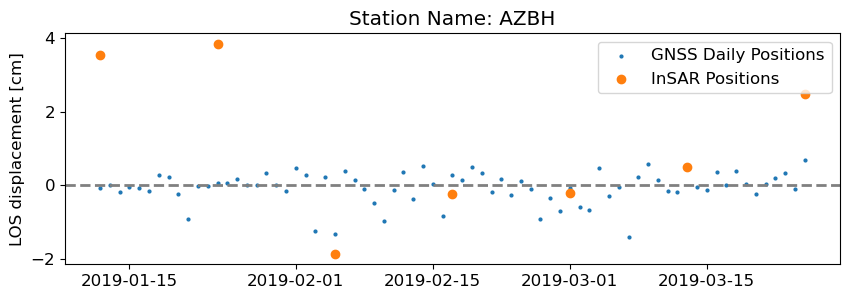

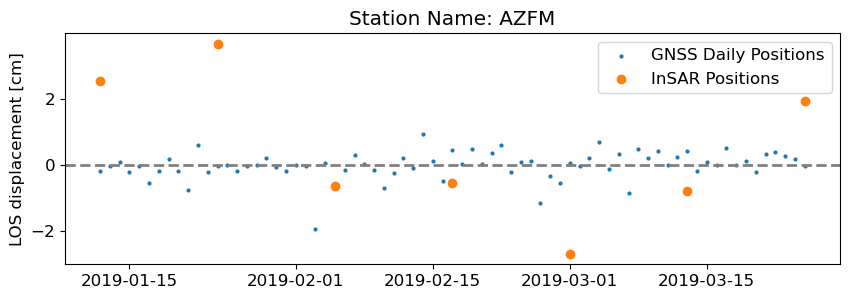

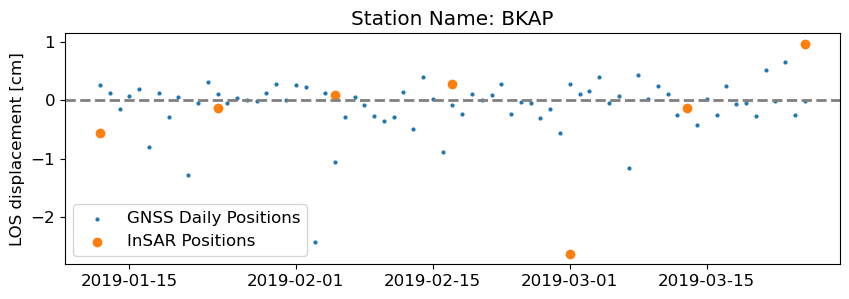

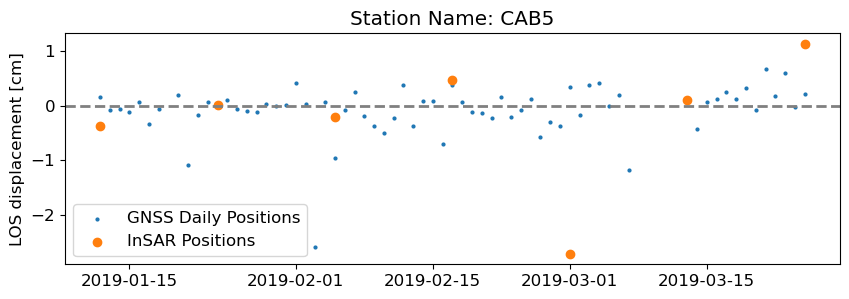

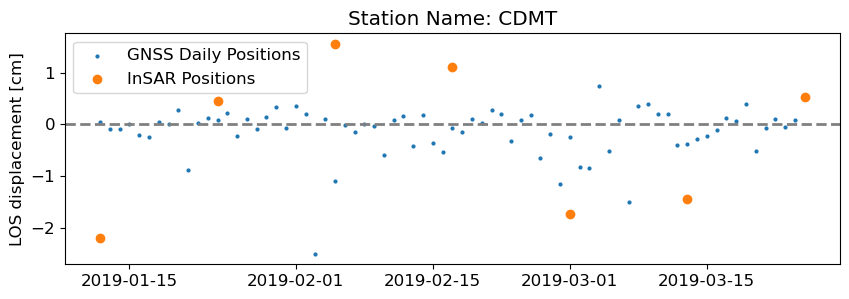

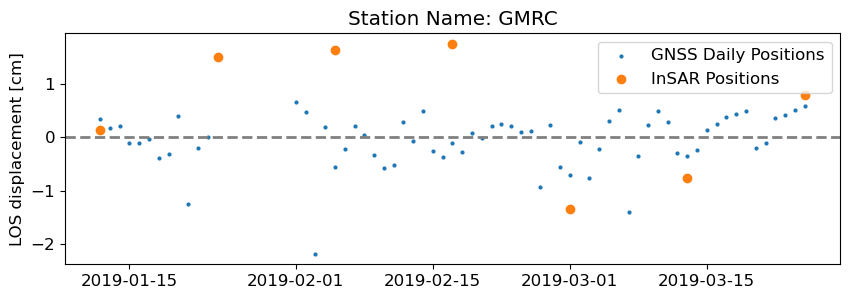

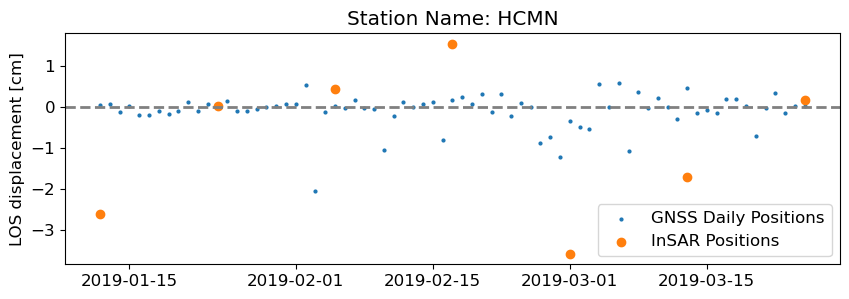

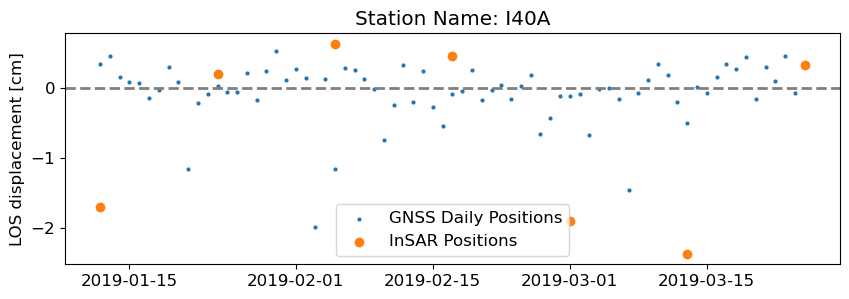

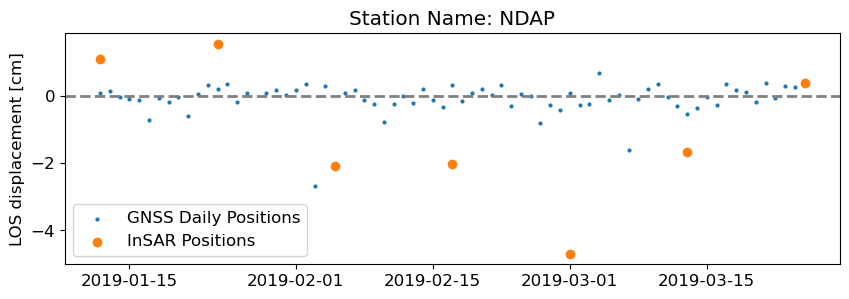

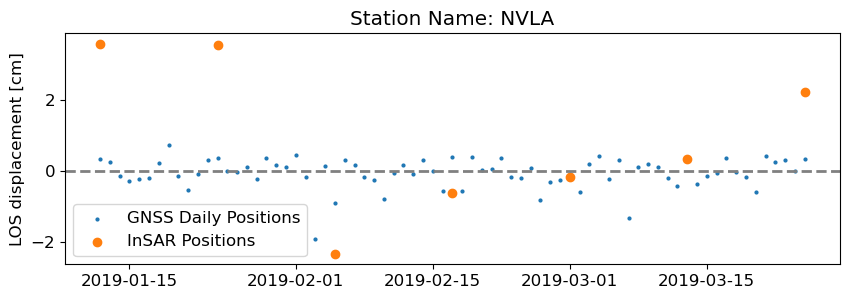

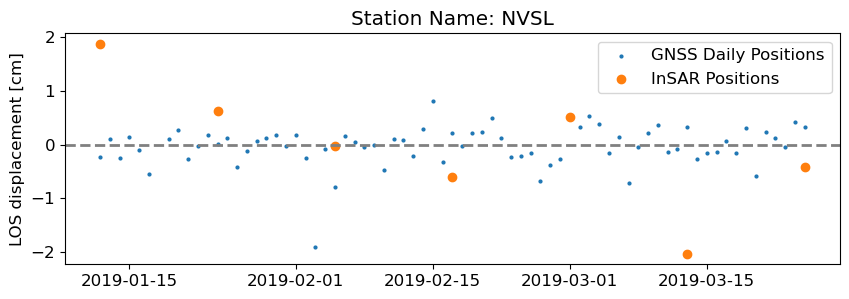

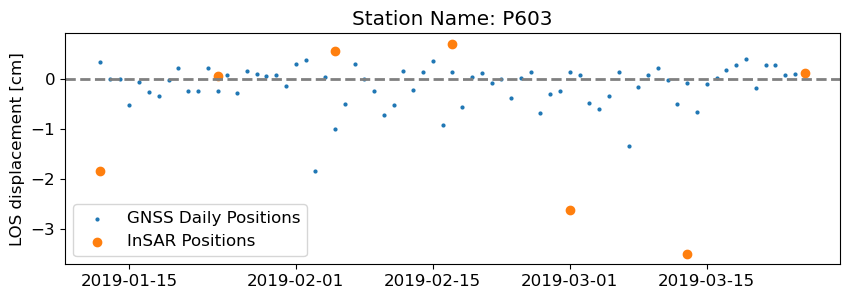

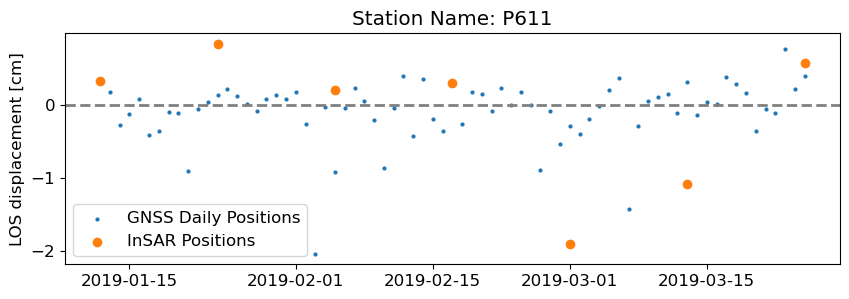

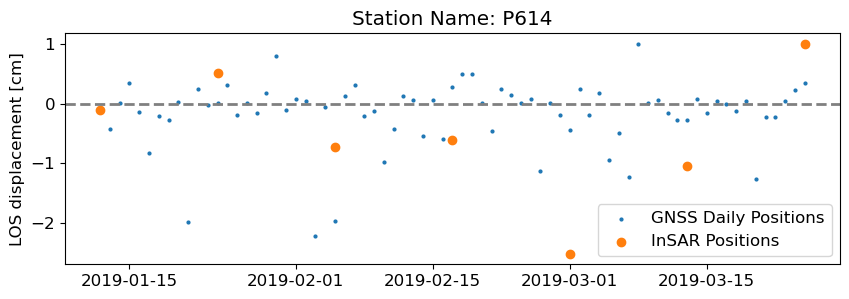

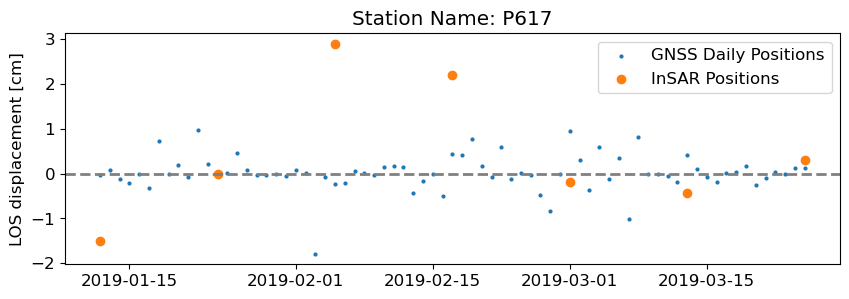

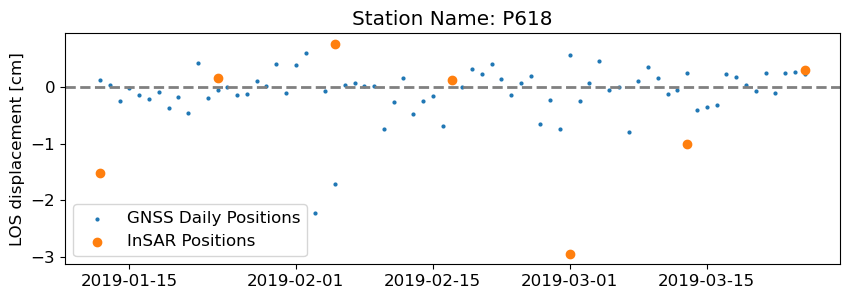

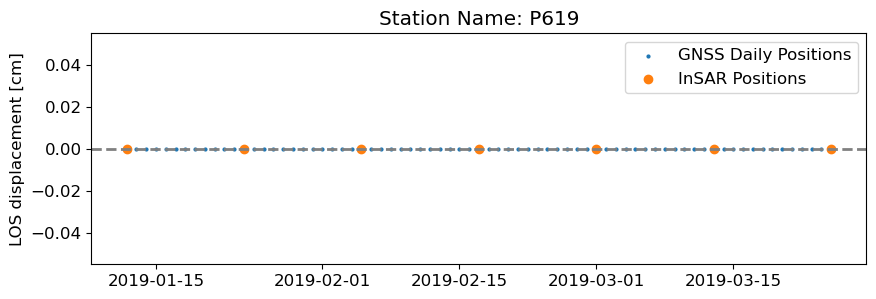

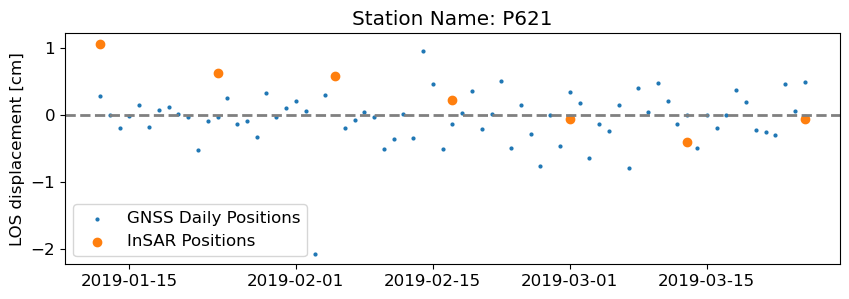

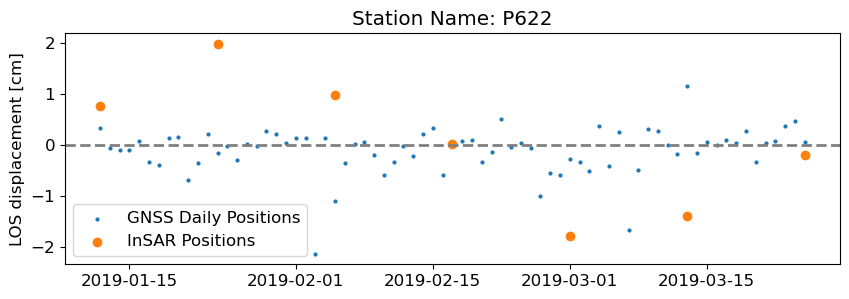

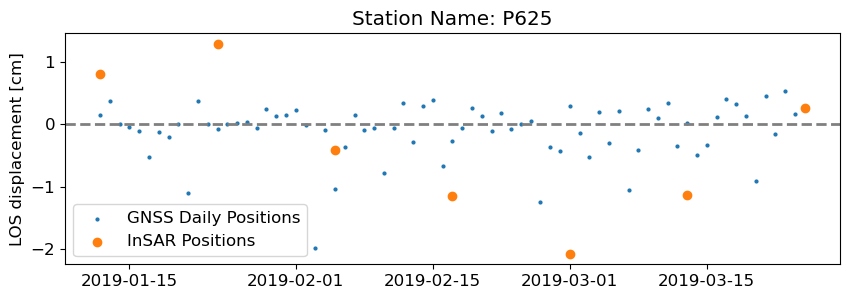

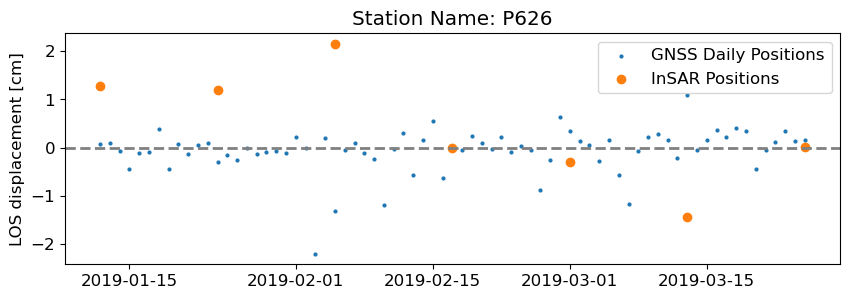

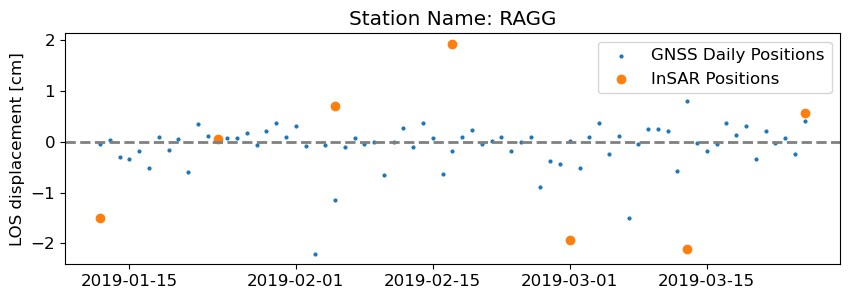

In [27]:
# grab the time-series file used for time function estimation given the template setup
template = readfile.read_template(os.path.join(mintpy_dir, 'smallbaselineApp.cfg'))
template = ut.check_template_auto_value(template)
insar_ts_file = TimeSeriesAnalysis.get_timeseries_filename(template, mintpy_dir)['velocity']['input']

# read the time-series file
insar_ts, atr = readfile.read(insar_ts_file, datasetName='timeseries')
mask = readfile.read(os.path.join(mintpy_dir, 'maskTempCoh.h5'))[0]
print(f'reading timeseries from file: {insar_ts_file}')

# Get date list
date_list = timeseries(insar_ts_file).get_date_list()
num_date = len(date_list)
date0, date1 = date_list[0], date_list[-1]
insar_dates = ptime.date_list2vector(date_list)[0]

# spatial reference
coord = ut.coordinate(atr)
ref_site = sitedata['sites'][site]['gps_ref_site_name']
ref_gnss_obj = gnss.get_gnss_class('UNR')(site = ref_site, data_dir = os.path.join(mintpy_dir,'GNSS'))
ref_lat, ref_lon = ref_gnss_obj.get_site_lat_lon()
ref_y, ref_x = coord.geo2radar(ref_lat, ref_lon)[:2]
if not mask[ref_y, ref_x]:
    raise ValueError(f'Given reference GNSS site ({ref_site}) is in mask-out unrelible region in InSAR! Change to a different site.')
ref_insar_dis = insar_ts[:, ref_y, ref_x]

# Plot displacements and velocity timeseries at GNSS station locations
num_site = len(site_names)
prog_bar = ptime.progressBar(maxValue=num_site)
for i, site_name in enumerate(site_names):
    prog_bar.update(i+1, suffix=f'{site_name} {i+1}/{num_site}')

    ## read data
    # read GNSS
    gnss_obj = gnss.get_gnss_class('UNR')(site = site_name, data_dir = os.path.join(mintpy_dir,'GNSS'))
    gnss_dates, gnss_dis, _, gnss_lalo = gnss_obj.get_los_displacement(atr, start_date=date0, end_date=date1, ref_site=ref_site)[:4]
    # shift GNSS to zero-mean in time [for plotting purpose]
    gnss_dis -= np.nanmedian(gnss_dis)

    # read InSAR
    y, x = coord.geo2radar(gnss_lalo[0], gnss_lalo[1])[:2]
    insar_dis = insar_ts[:, y, x] - ref_insar_dis
    # apply a constant shift in time to fit InSAR to GNSS
    comm_dates = sorted(list(set(gnss_dates) & set(insar_dates)))
    if comm_dates:
        insar_flag = [x in comm_dates for x in insar_dates]
        gnss_flag = [x in comm_dates for x in gnss_dates]
        insar_dis -= np.nanmedian(insar_dis[insar_flag] - gnss_dis[gnss_flag])

    ## plot figure
    if gnss_dis.size > 0 and np.any(~np.isnan(insar_dis)):
        fig, ax = plt.subplots(figsize=(10, 3))
        ax.axhline(color='grey',linestyle='dashed', linewidth=2)
        ax.scatter(gnss_dates, gnss_dis*100, s=2**2, label="GNSS Daily Positions")
        ax.scatter(insar_dates, insar_dis*100, label="InSAR Positions")
        # axis format
        ax.set_title(f"Station Name: {site_name}") 
        ax.set_ylabel('LOS displacement [cm]')
        ax.legend()
prog_bar.close()
plt.show()